# Importing libraries / Импорт библиотек:

In [1]:
import pandas as pd, seaborn as sns, numpy as np

from scipy.stats import iqr, trim_mean
from operator import attrgetter

from google.colab import drive
drive.mount("/content/drive")
data_path = "/content/drive/MyDrive/Recommendation system/"

Mounted at /content/drive


# Acquiring and processing the data / Получение и обработка данных:

In [2]:
df_lots = pd.read_csv(data_path + "data.csv", delimiter = ";", dtype = {"okpd2_code2": str})
df_participants = pd.read_csv(data_path + "participants.csv", delimiter = ";")

<ipython-input-2-7a2822675c2d>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lots = pd.read_csv(data_path + "data.csv", delimiter = ";", dtype = {"okpd2_code2": str})


## Deleting ambiguous values / Удаление неоднозначных значений:

In [3]:
ambiguous_okpd2_codes = ["2727", "2746", "2747", "2723", "2736", "2735", "2733", "2726", "2725", "2790", "2724", "2728", "2763", "2771"]

df_lots = df_lots[~df_lots["okpd2_code2"].isin(ambiguous_okpd2_codes)]

## Filling missing values / Заполнение пустых значений:

In [4]:
df_lots.fillna(value = "", inplace = True)

## Merging the data / Объединение данных:



In [5]:
df_merged = df_lots.merge(df_participants, how = "inner", on = "pn_lot_md5")

## Extracting years from dates / Вычленение года из дат:

In [6]:
df_lots["min_publish_date"] = pd.to_datetime(df_lots["min_publish_date"])
df_lots["year"] = df_lots["min_publish_date"].dt.year
df_lots["month"] = df_lots["min_publish_date"].dt.month

In [7]:
df_merged["min_publish_date"] = pd.to_datetime(df_merged["min_publish_date"])
df_merged["year"] = df_merged["min_publish_date"].dt.year
df_merged["month"] = df_merged["min_publish_date"].dt.month

# Exploratory data analysis / Анализ данных:

## OKPD2 codes / ОКПД2 коды:

<Axes: xlabel='count', ylabel='okpd2_code2'>

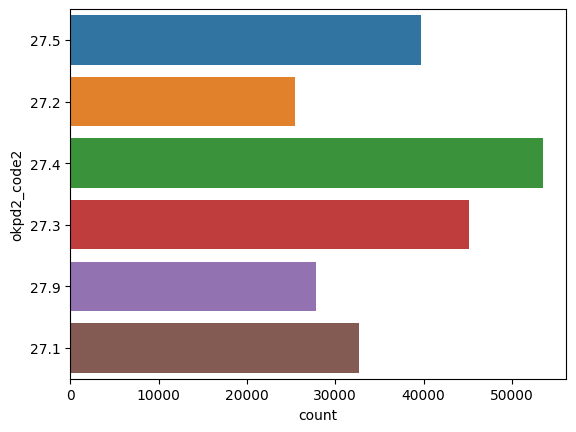

In [8]:
sns.countplot(data = df_lots, y = "okpd2_code2")

## Region codes / Коды регионов:

In [9]:
regions = df_merged["region_code"].value_counts(normalize = True)
regions = round(regions * 100, 2)
print(f"Top 5 region codes / Топ 5 кодов регионов:\n{regions[:5]}")

Top 5 region codes / Топ 5 кодов регионов:
77    13.34
78     7.00
23     3.39
50     3.37
24     3.18
Name: region_code, dtype: float64


## Lot price / Цена закупки:

In [10]:
trimmed_mean = trim_mean(a = df_lots["lot_price"], proportiontocut = .1)
i_q_r = iqr(df_lots["lot_price"])

print(f"Central tendency using trimmed mean / Мера центральной тенденции при использовании усечённого среднего = {round(trimmed_mean, 2)}")
print(f"Interquartile range / Интерквартильный размах = {round(i_q_r, 2)}")

Central tendency using trimmed mean / Мера центральной тенденции при использовании усечённого среднего = 425900.7
Interquartile range / Интерквартильный размах = 669435.32


## Lots / Закупки:

### Years / Годы:

<Axes: xlabel='year', ylabel='pn_lot_md5'>

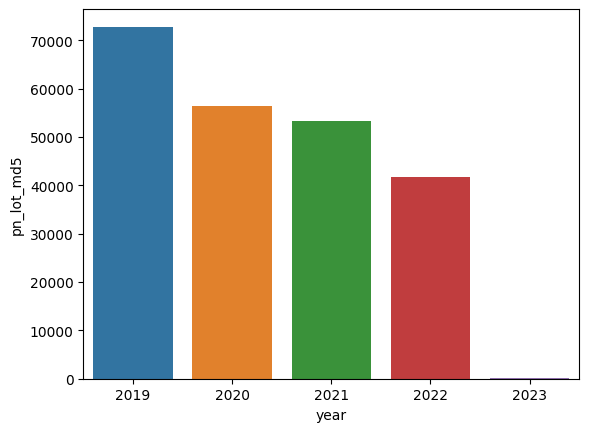

In [11]:
lots_by_years = df_lots.groupby("year")["pn_lot_md5"].agg(lambda value: value.count())
lots_by_months = df_lots.groupby("month")["pn_lot_md5"].agg(lambda value: value.count())

sns.barplot(x = lots_by_years.index, y = lots_by_years)

### Seasons / Сезоны:

<Axes: xlabel='month', ylabel='pn_lot_md5'>

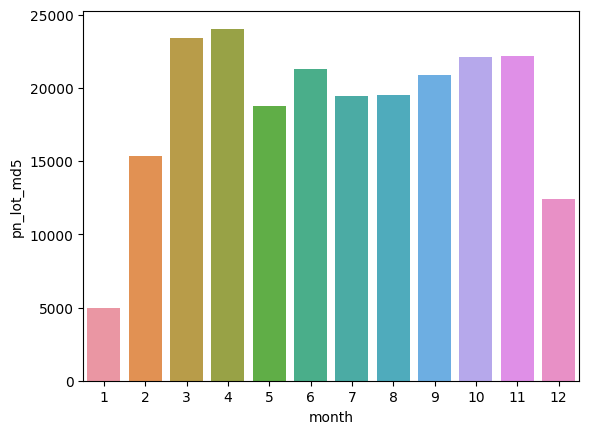

In [12]:
sns.barplot(x = lots_by_months.index, y = lots_by_months)

## Participants / Поставщики:

### Overall amount of the participants / Общее количество поставщиков:

<Axes: xlabel='year', ylabel='participant_inn_kpp'>

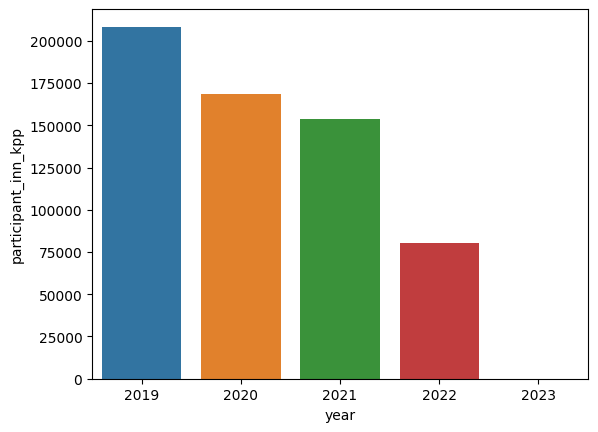

In [13]:
participants_not_unique = df_merged.groupby("year")["participant_inn_kpp"].agg(lambda value: value.count())

sns.barplot(x = participants_not_unique.index, y = participants_not_unique)

### Unique amount of the participants / Уникальное количество поставщиков:

<Axes: xlabel='year', ylabel='participant_inn_kpp'>

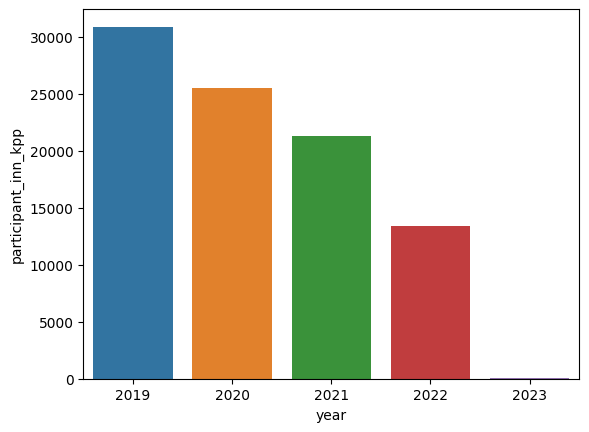

In [14]:
participants_unique = df_merged.groupby("year")["participant_inn_kpp"].nunique()

sns.barplot(x = participants_unique.index, y = participants_unique)

### Pairs of the participants and customers / Пары поставщиков и заказчиков:

In [15]:
participant_customer = df_merged.groupby(["participant_inn_kpp", "customer_inn_kpp"])["pn_lot_md5"].agg(lambda value: value.count())
participant_customer = participant_customer.sort_values(ascending = False)

print(f"Top 5 pairs / Топ 5 пар:\n{participant_customer[:5]}")

Top 5 pairs / Топ 5 пар:
participant_inn_kpp   customer_inn_kpp    
6452907540_645301001  6454038461_645001001    414
7017444166_701701001  1006004275_100601001    201
7724432569_772401001  7722765428_772201001    184
6455063686_645501001  6454038461_645001001    163
6318008725_631701001  6450925977_645001001    148
Name: pn_lot_md5, dtype: int64


### The amount of participations > 1 time / Количество участий больше одного раза:

In [16]:
unique_participations = df_merged.groupby("participant_inn_kpp")["pn_lot_md5"].nunique()
participations_percentage = np.sum(unique_participations > 1) / df_merged["participant_inn_kpp"].nunique()

print(f"The amount of participations > 1 time / Количество участий больше одного раза = {round(participations_percentage * 100, 2)}%")

The amount of participations > 1 time / Количество участий больше одного раза = 55.96%


### Cohort analysis / Когортный анализ:

In [17]:
df_merged["participation_month"] = df_merged["min_publish_date"].dt.to_period("M")
df_merged["cohort"] = df_merged.groupby("participant_inn_kpp")["min_publish_date"].transform("min").dt.to_period("M")

In [18]:
df_cohort = df_merged.groupby(["cohort", "participation_month"])\
            .agg(n_participants = ("participant_inn_kpp", "nunique"))\
            .reset_index(drop = False)

df_cohort["period_number"] = (df_cohort["participation_month"] - df_cohort["cohort"]).apply(attrgetter('n'))

In [19]:
cohort_pivot_table = df_cohort.pivot_table(index = "cohort", columns = "period_number", values = "n_participants")

In [20]:
cohort_size = cohort_pivot_table.iloc[:, 0]

retention_matrix = round(cohort_pivot_table.divide(cohort_size, axis = 0) * 100, 2)

retention_matrix.iloc[:10, :]

period_number,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
cohort,,,,,,,,,,,,,,,,,,,,,
2019-01,100.0,55.08,55.36,51.72,42.63,39.48,36.12,37.37,35.84,36.80,...,13.16,13.52,13.30,11.34,11.73,13.16,13.27,11.87,4.90,0.21
2019-02,100.0,41.99,36.29,29.10,25.36,24.56,25.33,24.56,25.56,23.73,...,7.15,8.09,6.77,6.98,7.44,7.40,7.02,2.88,0.12,NaN
2019-03,100.0,28.82,19.76,17.32,15.91,17.05,15.21,16.16,15.91,10.65,...,4.67,4.03,4.28,3.87,4.37,4.64,2.03,NaN,NaN,NaN
2019-04,100.0,18.90,15.67,14.55,14.60,13.75,15.04,14.08,8.88,4.33,...,3.45,3.59,3.51,3.48,3.64,0.99,0.03,NaN,NaN,NaN
2019-05,100.0,17.21,13.20,13.11,12.69,13.15,12.45,8.02,4.99,9.89,...,3.50,3.08,3.50,3.45,2.01,NaN,NaN,NaN,NaN,NaN
2019-06,100.0,14.20,15.09,12.47,12.57,12.89,6.97,3.56,8.80,8.07,...,2.72,2.57,2.72,1.41,0.05,NaN,NaN,NaN,NaN,NaN
2019-07,100.0,17.40,15.28,15.62,12.99,8.70,3.90,9.43,9.70,8.70,...,3.12,3.18,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,100.0,19.05,17.63,14.21,9.42,5.16,9.00,9.84,8.63,6.84,...,2.95,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,100.0,22.31,17.75,9.69,4.79,9.69,9.86,8.23,7.32,7.49,...,1.24,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='period_number', ylabel='cohort'>

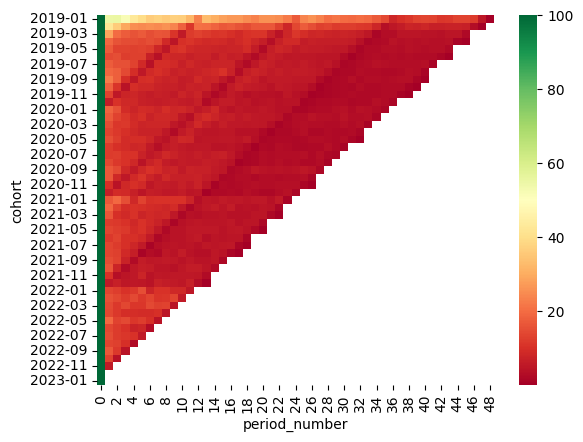

In [21]:
sns.heatmap(data = retention_matrix, cmap = "RdYlGn")